In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.anova import anova_lm
%matplotlib inline
plt.rcParams['figure.figsize']=15,15

# Yan regresyonları gerçekleştirmek için fonksiyonlar
def generate_combinations(explanatory_variables):
    combinations = {}
    for var in explanatory_variables:
        combinations[var] = [element for element in explanatory_variables if element != var]
    return combinations

def make_auxiliary_regressions(data, explanatory_variables):
    predictors = generate_combinations(explanatory_variables)
    print(predictors)
    rsqs = {}
    for explanatory_variable in explanatory_variables:
        #print("Regressing {0} over {1}".format(predictors[explanatory_variable], explanatory_variable))
        auxiliary_model = OLS(data[explanatory_variable].astype(float), add_constant(data[predictors[explanatory_variable]]), hasconst = True).fit()
        # output the r squared
        print("R-squared for explanatory variable {0}: {1} ".format(explanatory_variable,auxiliary_model.rsquared))
        rsqs[explanatory_variable] = auxiliary_model.rsquared
    return rsqs

def detect_multicollinearity(data, explanatory_variables, response_variables, vif_threshold = 10):
    naive_model = OLS(data[response_variables].astype(float), add_constant(data[explanatory_variables]).astype(float), hasconst = True).fit()
    threshold_Rsq = naive_model.rsquared
    
    possible_variables = []
    droppable_variables = []
    # test multicollinearity
    rsquareds = make_auxiliary_regressions(data, explanatory_variables)
    for key, val in rsquareds.items():
        vif = 1/(1 - val)
        if val > threshold_Rsq and vif > vif_threshold:
            droppable_variables.append(key)
        else:
            possible_variables.append(key)
        print("Tolerance for {0}: {1}".format(key, 1 - val))
        print("Variance inflation factor for {0}: {1}".format(key, vif)) 
    
        
    print("Low multicollinearity variables: ")
    print(possible_variables)
    print("May be dropped: ")
    print(droppable_variables)
    return possible_variables
        

# Introduction
The purpose of this notebook is to use the energy data of Europe after the 21th century to see which type of energy will be sufficient to supply the energy demands (with respect to population) of Europe.

In [2]:
data = pd.read_excel(r"C:\Users\kagan\OneDrive\Masaüstü\DATA\avrupa_enerji.xlsx")
data["scaledPop"] = data["population"] / (10**6)
data.head(10)

,Unnamed: 0,year,country,gdp,carbon_intensity_elec,electricity_demand,electricity_generation,greenhouse_gas_emissions,net_elec_imports,population,...,low_carbon_share_elec,nuclear_share_elec,oil_share_elec,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,renewables_share_elec,solar_share_elec,wind_share_elec,ScaledPop,scaledPop
0,6576,2000,Europe,NaN,378.941,4297.07,4305.52,1631.54,-8.45,727919596,...,45.693,27.173,6.457,0.957,0.155,18.520,0.003,0.517,727919.596,727.919596
1,6577,2001,Europe,NaN,374.795,4377.36,4384.48,1643.28,-7.12,727846044,...,46.185,27.506,6.279,0.994,0.151,18.680,0.005,0.610,727846.044,727.846044
2,6578,2002,Europe,NaN,380.934,4418.95,4414.99,1681.82,3.96,727924375,...,45.120,27.819,6.420,1.116,0.155,17.301,0.006,0.825,727924.375,727.924375
3,6579,2003,Europe,NaN,387.538,4513.54,4514.45,1749.52,-0.91,728428191,...,43.968,27.568,5.931,1.279,0.169,16.400,0.009,0.993,728428.191,728.428191
4,6580,2004,Europe,NaN,376.938,4607.52,4607.95,1736.91,-0.43,729184823,...,45.019,27.313,5.224,1.496,0.171,17.707,0.015,1.297,729184.823,729.184823
5,6581,2005,Europe,NaN,375.596,4665.78,4668.66,1753.53,-2.88,729990437,...,44.836,26.693,5.092,1.691,0.170,18.143,0.032,1.533,729990.437,729.990437
6,6582,2006,Europe,NaN,380.192,4752.45,4757.67,1808.83,-5.22,730916003,...,44.307,26.297,4.951,1.878,0.193,18.009,0.053,1.758,730916.003,730.916003
7,6583,2007,Europe,NaN,380.945,4807.62,4811.12,1832.77,-3.50,732469869,...,43.756,24.990,4.401,2.065,0.214,18.766,0.079,2.207,732469.869,732.469869
8,6584,2008,Europe,NaN,373.268,4849.80,4855.52,1812.41,-5.72,734351485,...,44.418,24.825,4.132,2.259,0.221,19.593,0.154,2.499,734351.485,734.351485
9,6585,2009,Europe,NaN,360.436,4613.87,4618.10,1664.53,-4.23,736016704,...,46.375,25.032,3.896,2.598,0.238,21.343,0.306,2.921,736016.704,736.016704


In [3]:
# variables of interest
variables = ["year", "gdp", "carbon_intensity_elec", "electricity_demand", "electricity_generation", 
             "greenhouse_gas_emissions", "net_elec_imports", "population"]
# energy variables
energy_vars = [feature for feature in data.columns if "share_elec" in feature]
# merge two lists
variables = variables + energy_vars

In [4]:
data["sustainability"] = (data["electricity_generation"] * 10**10) / (data["carbon_intensity_elec"] * data["greenhouse_gas_emissions"] * data["scaledPop"] * data["electricity_demand"])

In [5]:
data.columns

Index(['Unnamed: 0', 'year', 'country', 'gdp', 'carbon_intensity_elec',
       'electricity_demand', 'electricity_generation',
       'greenhouse_gas_emissions', 'net_elec_imports', 'population',
       'biofuel_share_elec', 'coal_share_elec', 'fossil_share_elec',
       'gas_share_elec', 'hydro_share_elec', 'low_carbon_share_elec',
       'nuclear_share_elec', 'oil_share_elec', 'other_renewables_share_elec',
       'other_renewables_share_elec_exc_biofuel', 'renewables_share_elec',
       'solar_share_elec', 'wind_share_elec', 'ScaledPop', 'scaledPop',
       'sustainability'],
      dtype='object')

In [6]:
data

,Unnamed: 0,year,country,gdp,carbon_intensity_elec,electricity_demand,electricity_generation,greenhouse_gas_emissions,net_elec_imports,population,...,nuclear_share_elec,oil_share_elec,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,renewables_share_elec,solar_share_elec,wind_share_elec,ScaledPop,scaledPop,sustainability
0,6576,2000,Europe,NaN,378.941,4297.07,4305.52,1631.54,-8.45,727919596,...,27.173,6.457,0.957,0.155,18.520,0.003,0.517,727919.596,727.919596,22.263859
1,6577,2001,Europe,NaN,374.795,4377.36,4384.48,1643.28,-7.12,727846044,...,27.506,6.279,0.994,0.151,18.680,0.005,0.610,727846.044,727.846044,22.344001
2,6578,2002,Europe,NaN,380.934,4418.95,4414.99,1681.82,3.96,727924375,...,27.819,6.420,1.116,0.155,17.301,0.006,0.825,727924.375,727.924375,21.423732
3,6579,2003,Europe,NaN,387.538,4513.54,4514.45,1749.52,-0.91,728428191,...,27.568,5.931,1.279,0.169,16.400,0.009,0.993,728428.191,728.428191,20.251985
4,6580,2004,Europe,NaN,376.938,4607.52,4607.95,1736.91,-0.43,729184823,...,27.313,5.224,1.496,0.171,17.707,0.015,1.297,729184.823,729.184823,20.948632
5,6581,2005,Europe,NaN,375.596,4665.78,4668.66,1753.53,-2.88,729990437,...,26.693,5.092,1.691,0.170,18.143,0.032,1.533,729990.437,729.990437,20.812136
6,6582,2006,Europe,NaN,380.192,4752.45,4757.67,1808.83,-5.22,730916003,...,26.297,4.951,1.878,0.193,18.009,0.053,1.758,730916.003,730.916003,19.916296
7,6583,2007,Europe,NaN,380.945,4807.62,4811.12,1832.77,-3.50,732469869,...,24.990,4.401,2.065,0.214,18.766,0.079,2.207,732469.869,732.469869,19.568433
8,6584,2008,Europe,NaN,373.268,4849.80,4855.52,1812.41,-5.72,734351485,...,24.825,4.132,2.259,0.221,19.593,0.154,2.499,734351.485,734.351485,20.152584
9,6585,2009,Europe,NaN,360.436,4613.87,4618.10,1664.53,-4.23,736016704,...,25.032,3.896,2.598,0.238,21.343,0.306,2.921,736016.704,736.016704,22.666816


# Model formation
To combine the information regarding all of environmental stress and proportion of population supplied with electricity, the following variable was formed:

sustainability = (electricity_generation * electricity_demand) / (carbon_intensity_elec * greenhouse_gas_emissions * scaledPop) 

ß = coefficient matrix

E = matrix of all energy resources

Model 1: linear-linear model
sustainability ~ m + ß * E

Model 2: linear-logarithmic model
sustainability ~ m + log(ß * E)

Model 3: logarithmic-linear model
log(sustainability) ~ m + ß * E 

Model 4: logarithmic-logarithmic model
log(sustainability) ~ m + log(ß * E)

Model 5: Inverse model
sustainability ~ m + 1/(ß * E)

In [7]:
from statsmodels.api import OLS, add_constant
explanatory_variables_ = ['biofuel_share_elec', 'coal_share_elec', 'fossil_share_elec',
       'gas_share_elec', 'hydro_share_elec', 'low_carbon_share_elec',
       'nuclear_share_elec', 'oil_share_elec', 'other_renewables_share_elec',
       'other_renewables_share_elec_exc_biofuel', 'renewables_share_elec',
       'solar_share_elec', 'wind_share_elec']
explanatory_variables = data[explanatory_variables_]
response_variable = data["sustainability"]
# lin-lin
model_1 = OLS(response_variable, add_constant(explanatory_variables)).fit()
# lin-log
model_2 = OLS(response_variable, add_constant(explanatory_variables.apply(np.log))).fit()
# log-lin
model_3 = OLS(response_variable.apply(np.log), add_constant(explanatory_variables)).fit()
# log-log
model_4 = OLS(response_variable.apply(np.log), add_constant(explanatory_variables.apply(np.log))).fit()
# inverse model
model_5 = OLS(response_variable, add_constant(1/explanatory_variables)).fit()

In [8]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sustainability   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     160.0
Date:                Thu, 15 Jun 2023   Prob (F-statistic):           5.73e-09
Time:                        22:24:27   Log-Likelihood:                -8.8510
No. Observations:                  22   AIC:                             43.70
Df Residuals:                       9   BIC:                             57.89
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      15.7187      8.668      1.813      0.103      -3.890      35.327
biofuel_share_elec                        665.0532    384.223      1.731      0.118    -204.121    1534.227
coal_share_elec                          -419.0401    460.989     -0.909      0.387   -1461.870     623.790
fossil_share_elec                         418.0841    460.938      0.907      0.388    -624.631    1460.799
gas_share_elec                           -418.1012    461.087     -0.907      0.388   -1461.152     624.949
hydro_share_elec                         -670.7300    351.064     -1.911      0.088   -1464.892     123.432
low_carbon_share_elec                    1153.7841    502.445      2.296      0.047      17.175    2290.393
nuclear_share_elec                      -1152.2884    502.317     -2.294      0.047   -2288.609     -15.967
oil_share_elec                           -420.7813    461.167     -0.912      0.385   -1464.014     622.452
other_renewables_share_elec             -1343.1611    602.649     -2.229      0.053   -2706.449      20.127
other_renewables_share_elec_exc_biofuel   697.2105    385.330      1.809      0.104    -174.466    1568.887
renewables_share_elec                    -482.3701    347.258     -1.389      0.198   -1267.923     303.182
solar_share_elec                         -665.3047    350.351     -1.899      0.090   -1457.853     127.244
wind_share_elec                          -671.7845    351.505     -1.911      0.088   -1466.944     123.375
==============================================================================
Omnibus:                        0.269   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.874   Jarque-Bera (JB):                0.451
Skew:                          -0.051   Prob(JB):                        0.798
Kurtosis:                       2.306   Cond. No.                     2.20e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.45e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [9]:
model_1.mse_total

29.391771073839024

In [10]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sustainability   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     333.2
Date:                Thu, 15 Jun 2023   Prob (F-statistic):           1.88e-09
Time:                        22:24:28   Log-Likelihood:                 1.3646
No. Observations:                  22   AIC:                             25.27
Df Residuals:                       8   BIC:                             40.55
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                     660.9563    324.169      2.039      0.076     -86.578    1408.491
biofuel_share_elec                        -11.4853     47.171     -0.243      0.814    -120.261      97.291
coal_share_elec                           -22.7319     17.711     -1.284      0.235     -63.572      18.109
fossil_share_elec                         -76.9174     70.113     -1.097      0.305    -238.599      84.764
gas_share_elec                            -12.7605     20.378     -0.626      0.549     -59.752      34.231
hydro_share_elec                            5.7330      6.707      0.855      0.418      -9.734      21.200
low_carbon_share_elec                     -60.1515     60.739     -0.990      0.351    -200.216      79.913
nuclear_share_elec                          4.8030     21.224      0.226      0.827     -44.139      53.745
oil_share_elec                             -0.9833      3.904     -0.252      0.807      -9.985       8.019
other_renewables_share_elec                12.1786     51.696      0.236      0.820    -107.032     131.389
other_renewables_share_elec_exc_biofuel     0.7932      3.083      0.257      0.803      -6.315       7.902
renewables_share_elec                      -5.8419     18.941     -0.308      0.766     -49.520      37.836
solar_share_elec                            0.3566      0.704      0.506      0.626      -1.268       1.981
wind_share_elec                            -0.5779      3.242     -0.178      0.863      -8.055       6.899
==============================================================================
Omnibus:                        1.267   Durbin-Watson:                   2.917
Prob(Omnibus):                  0.531   Jarque-Bera (JB):                0.773
Skew:                           0.456   Prob(JB):                        0.679
Kurtosis:                       2.885   Cond. No.                     3.90e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
model_2.mse_total

29.391771073839024

In [12]:
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sustainability   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     448.7
Date:                Thu, 15 Jun 2023   Prob (F-statistic):           5.68e-11
Time:                        22:24:30   Log-Likelihood:                 75.336
No. Observations:                  22   AIC:                            -124.7
Df Residuals:                       9   BIC:                            -110.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.2586      0.189      1.370      0.204      -0.168       0.686
biofuel_share_elec                          7.6951      8.369      0.919      0.382     -11.237      26.627
coal_share_elec                            -3.8746     10.041     -0.386      0.709     -26.589      18.840
fossil_share_elec                           3.8632     10.040      0.385      0.709     -18.849      26.575
gas_share_elec                             -3.8465     10.043     -0.383      0.711     -26.566      18.873
hydro_share_elec                          -20.1025      7.647     -2.629      0.027     -37.401      -2.804
low_carbon_share_elec                      21.9983     10.944      2.010      0.075      -2.759      46.755
nuclear_share_elec                        -21.9286     10.941     -2.004      0.076     -46.679       2.822
oil_share_elec                             -3.8763     10.045     -0.386      0.709     -26.600      18.847
other_renewables_share_elec               -27.9089     13.127     -2.126      0.062     -57.603       1.786
other_renewables_share_elec_exc_biofuel     8.3074      8.393      0.990      0.348     -10.679      27.294
renewables_share_elec                      -1.8402      7.564     -0.243      0.813     -18.951      15.270
solar_share_elec                          -20.0222      7.631     -2.624      0.028     -37.285      -2.759
wind_share_elec                           -20.1397      7.656     -2.630      0.027     -37.460      -2.820
==============================================================================
Omnibus:                        3.436   Durbin-Watson:                   2.423
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                1.681
Skew:                          -0.554   Prob(JB):                        0.431
Kurtosis:                       3.779   Cond. No.                     2.20e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.45e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [13]:
model_3.mse_total

0.038990698865751114

In [14]:
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sustainability   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     382.0
Date:                Thu, 15 Jun 2023   Prob (F-statistic):           1.09e-09
Time:                        22:24:31   Log-Likelihood:                 75.742
No. Observations:                  22   AIC:                            -123.5
Df Residuals:                       8   BIC:                            -108.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       3.4987     11.029      0.317      0.759     -21.933      28.931
biofuel_share_elec                         -2.1225      1.605     -1.323      0.223      -5.823       1.578
coal_share_elec                            -0.5438      0.603     -0.903      0.393      -1.933       0.846
fossil_share_elec                          -0.6968      2.385     -0.292      0.778      -6.197       4.804
gas_share_elec                             -0.0996      0.693     -0.144      0.889      -1.698       1.499
hydro_share_elec                            0.2876      0.228      1.260      0.243      -0.239       0.814
low_carbon_share_elec                       0.6938      2.066      0.336      0.746      -4.071       5.459
nuclear_share_elec                          0.3778      0.722      0.523      0.615      -1.287       2.043
oil_share_elec                              0.0282      0.133      0.212      0.837      -0.278       0.334
other_renewables_share_elec                 2.2947      1.759      1.305      0.228      -1.761       6.350
other_renewables_share_elec_exc_biofuel    -0.0828      0.105     -0.790      0.453      -0.325       0.159
renewables_share_elec                      -0.2649      0.644     -0.411      0.692      -1.751       1.221
solar_share_elec                            0.0024      0.024      0.098      0.924      -0.053       0.058
wind_share_elec                             0.0334      0.110      0.303      0.770      -0.221       0.288
==============================================================================
Omnibus:                        1.540   Durbin-Watson:                   3.086
Prob(Omnibus):                  0.463   Jarque-Bera (JB):                1.011
Skew:                           0.520   Prob(JB):                        0.603
Kurtosis:                       2.853   Cond. No.                     3.90e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
model_4.mse_total

0.038990698865751114

In [16]:
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sustainability   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     429.6
Date:                Thu, 15 Jun 2023   Prob (F-statistic):           6.83e-10
Time:                        22:24:32   Log-Likelihood:                 4.1538
No. Observations:                  22   AIC:                             19.69
Df Residuals:                       8   BIC:                             34.97
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                     -21.6686     32.137     -0.674      0.519     -95.778      52.440
biofuel_share_elec                         25.9493     45.387      0.572      0.583     -78.713     130.612
coal_share_elec                           309.5175    116.249      2.663      0.029      41.447     577.588
fossil_share_elec                        1836.3330   1267.234      1.449      0.185   -1085.914    4758.580
gas_share_elec                             92.5922    153.993      0.601      0.564    -262.517     447.701
hydro_share_elec                          -92.6694     48.643     -1.905      0.093    -204.841      19.503
low_carbon_share_elec                     573.0103   1265.396      0.453      0.663   -2344.997    3491.018
nuclear_share_elec                       -266.8186    246.038     -1.084      0.310    -834.183     300.545
oil_share_elec                             -6.1742     11.433     -0.540      0.604     -32.538      20.190
other_renewables_share_elec               -31.4141     55.151     -0.570      0.585    -158.591      95.763
other_renewables_share_elec_exc_biofuel    -0.1255      0.251     -0.501      0.630      -0.703       0.452
renewables_share_elec                      16.6166    187.751      0.089      0.932    -416.337     449.570
solar_share_elec                            0.0036      0.007      0.528      0.612      -0.012       0.019
wind_share_elec                            -1.4826      3.009     -0.493      0.635      -8.422       5.457
==============================================================================
Omnibus:                        1.512   Durbin-Watson:                   2.994
Prob(Omnibus):                  0.470   Jarque-Bera (JB):                0.748
Skew:                           0.450   Prob(JB):                        0.688
Kurtosis:                       3.079   Cond. No.                     2.27e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
model_5.mse_total

29.391771073839024

# Normality tests on model errors

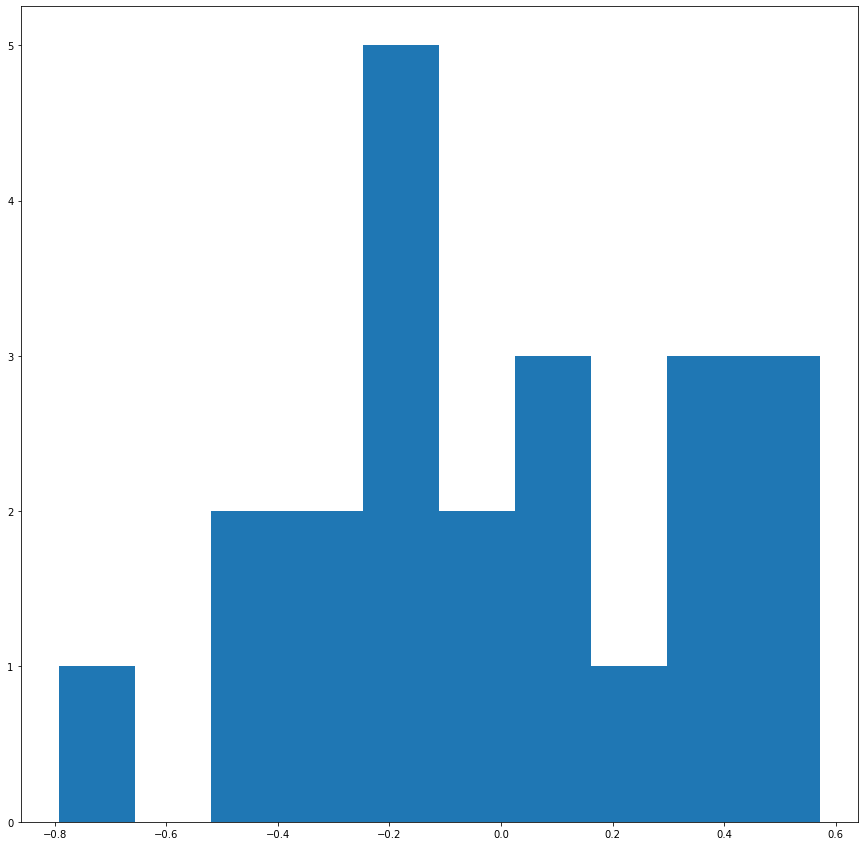

In [18]:
_ = plt.hist(model_1.resid)

In [19]:
from scipy.stats import shapiro
shapiro_test = shapiro(model_1.resid)
print("Shapiro-Wilk test statistic: ", shapiro_test.statistic)
print("Shapiro-Wilk test result: ", shapiro_test.pvalue)
print("Errors are normally distributed" if shapiro_test.pvalue >= 0.05 else "Errors are not normally distributed")

Shapiro-Wilk test statistic:  0.9601444005966187
Shapiro-Wilk test result:  0.4922039210796356
Errors are normally distributed


# Multicollinearity Checks

### Correlation matrix

In [20]:
data[explanatory_variables_].corr()

,biofuel_share_elec,coal_share_elec,fossil_share_elec,gas_share_elec,hydro_share_elec,low_carbon_share_elec,nuclear_share_elec,oil_share_elec,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,renewables_share_elec,solar_share_elec,wind_share_elec
biofuel_share_elec,1.000000,-0.894605,-0.908130,0.320346,0.218264,0.908130,-0.947289,-0.960610,0.999750,0.806975,0.956163,0.948276,0.963990
coal_share_elec,-0.894605,1.000000,0.928466,-0.406423,-0.326134,-0.928466,0.843011,0.824472,-0.890731,-0.624926,-0.944733,-0.924137,-0.964662
fossil_share_elec,-0.908130,0.928466,1.000000,-0.064214,-0.500049,-1.000000,0.791882,0.784413,-0.903619,-0.618510,-0.987151,-0.984236,-0.964581
gas_share_elec,0.320346,-0.406423,-0.064214,1.000000,-0.437880,0.064214,-0.488950,-0.490627,0.323977,0.358787,0.178018,0.126076,0.284866
hydro_share_elec,0.218264,-0.326134,-0.500049,-0.437880,1.000000,0.500049,-0.169144,-0.099574,0.213893,0.062242,0.434269,0.374545,0.295099
low_carbon_share_elec,0.908130,-0.928466,-1.000000,0.064214,0.500049,1.000000,-0.791882,-0.784413,0.903619,0.618510,0.987151,0.984236,0.964581
nuclear_share_elec,-0.947289,0.843011,0.791882,-0.488950,-0.169144,-0.791882,1.000000,0.963801,-0.949341,-0.826115,-0.879287,-0.847553,-0.893909
oil_share_elec,-0.960610,0.824472,0.784413,-0.490627,-0.099574,-0.784413,0.963801,1.000000,-0.962298,-0.827295,-0.863994,-0.838387,-0.883615
other_renewables_share_elec,0.999750,-0.890731,-0.903619,0.323977,0.213893,0.903619,-0.949341,-0.962298,1.000000,0.819988,0.953181,0.943772,0.961355
other_renewables_share_elec_exc_biofuel,0.806975,-0.624926,-0.618510,0.358787,0.062242,0.618510,-0.826115,-0.827295,0.819988,1.000000,0.698565,0.651609,0.713911


In [21]:
data[explanatory_variables_].corr()[(data[explanatory_variables_].corr() < .4) & (data[explanatory_variables_].corr() > -.4)]

,biofuel_share_elec,coal_share_elec,fossil_share_elec,gas_share_elec,hydro_share_elec,low_carbon_share_elec,nuclear_share_elec,oil_share_elec,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,renewables_share_elec,solar_share_elec,wind_share_elec
biofuel_share_elec,NaN,NaN,NaN,0.320346,0.218264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coal_share_elec,NaN,NaN,NaN,NaN,-0.326134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fossil_share_elec,NaN,NaN,NaN,-0.064214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gas_share_elec,0.320346,NaN,-0.064214,NaN,NaN,0.064214,NaN,NaN,0.323977,0.358787,0.178018,0.126076,0.284866
hydro_share_elec,0.218264,-0.326134,NaN,NaN,NaN,NaN,-0.169144,-0.099574,0.213893,0.062242,NaN,0.374545,0.295099
low_carbon_share_elec,NaN,NaN,NaN,0.064214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nuclear_share_elec,NaN,NaN,NaN,NaN,-0.169144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oil_share_elec,NaN,NaN,NaN,NaN,-0.099574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
other_renewables_share_elec,NaN,NaN,NaN,0.323977,0.213893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
other_renewables_share_elec_exc_biofuel,NaN,NaN,NaN,0.358787,0.062242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Partial regression and VIFs

In [22]:
print(detect_multicollinearity(data, explanatory_variables_, "sustainability"))

{'biofuel_share_elec': ['coal_share_elec', 'fossil_share_elec', 'gas_share_elec', 'hydro_share_elec', 'low_carbon_share_elec', 'nuclear_share_elec', 'oil_share_elec', 'other_renewables_share_elec', 'other_renewables_share_elec_exc_biofuel', 'renewables_share_elec', 'solar_share_elec', 'wind_share_elec'], 'coal_share_elec': ['biofuel_share_elec', 'fossil_share_elec', 'gas_share_elec', 'hydro_share_elec', 'low_carbon_share_elec', 'nuclear_share_elec', 'oil_share_elec', 'other_renewables_share_elec', 'other_renewables_share_elec_exc_biofuel', 'renewables_share_elec', 'solar_share_elec', 'wind_share_elec'], 'fossil_share_elec': ['biofuel_share_elec', 'coal_share_elec', 'gas_share_elec', 'hydro_share_elec', 'low_carbon_share_elec', 'nuclear_share_elec', 'oil_share_elec', 'other_renewables_share_elec', 'other_renewables_share_elec_exc_biofuel', 'renewables_share_elec', 'solar_share_elec', 'wind_share_elec'], 'gas_share_elec': ['biofuel_share_elec', 'coal_share_elec', 'fossil_share_elec', 'hy

<ipython-input-1-57a454dc304f>:37: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1/(1 - val)


In [23]:
explanatory_variables = data[["nuclear_share_elec", "renewables_share_elec"]]
model = OLS(response_variable, add_constant(explanatory_variables), hasconst = True).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sustainability   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     121.1
Date:                Thu, 15 Jun 2023   Prob (F-statistic):           1.54e-11
Time:                        22:24:41   Log-Likelihood:                -39.064
No. Observations:                  22   AIC:                             84.13
Df Residuals:                      19   BIC:                             87.40
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -47.7261     13.454     -3.547      0.002     -75.885     -19.567
nuclear_share_elec        1.7271      0.437      3.949      0.001       0.812       2.642
renewables_share_elec     1.2180      0.114     10.642      0.000       0.978       1.458
==============================================================================
Omnibus:                        3.027   Durbin-Watson:                   0.611
Prob(Omnibus):                  0.220   Jarque-Bera (JB):                1.356
Skew:                           0.390   Prob(JB):                        0.508
Kurtosis:                       3.933   Cond. No.                     1.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Heteroskedasticity tests on model errors


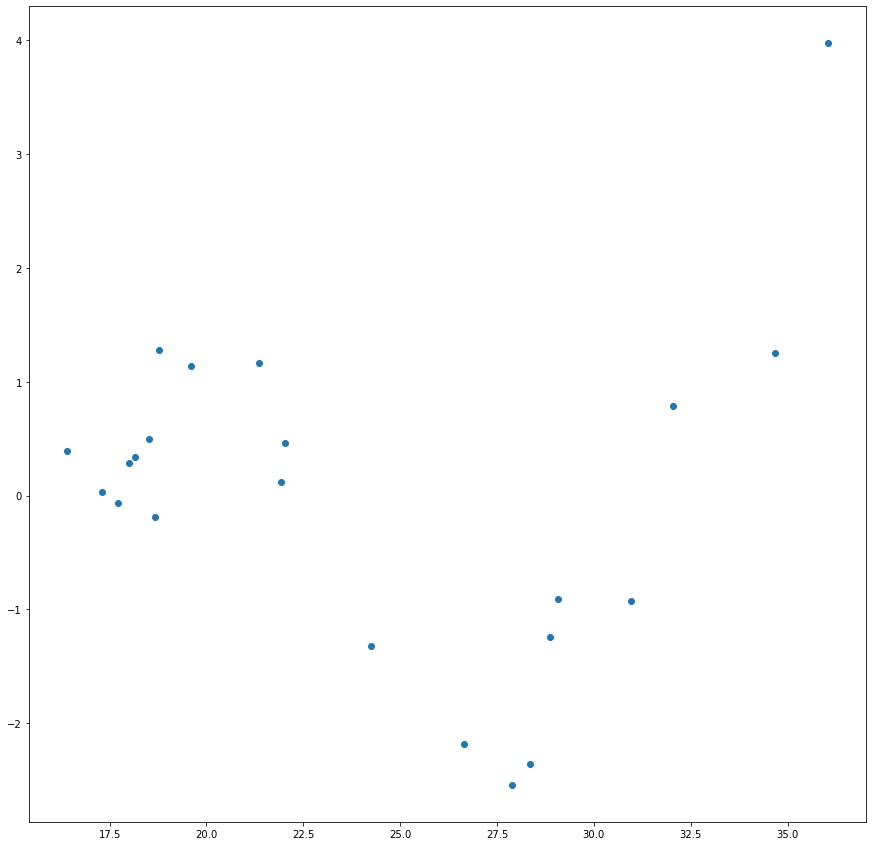

In [24]:
plt.scatter(data["renewables_share_elec"], model.resid)

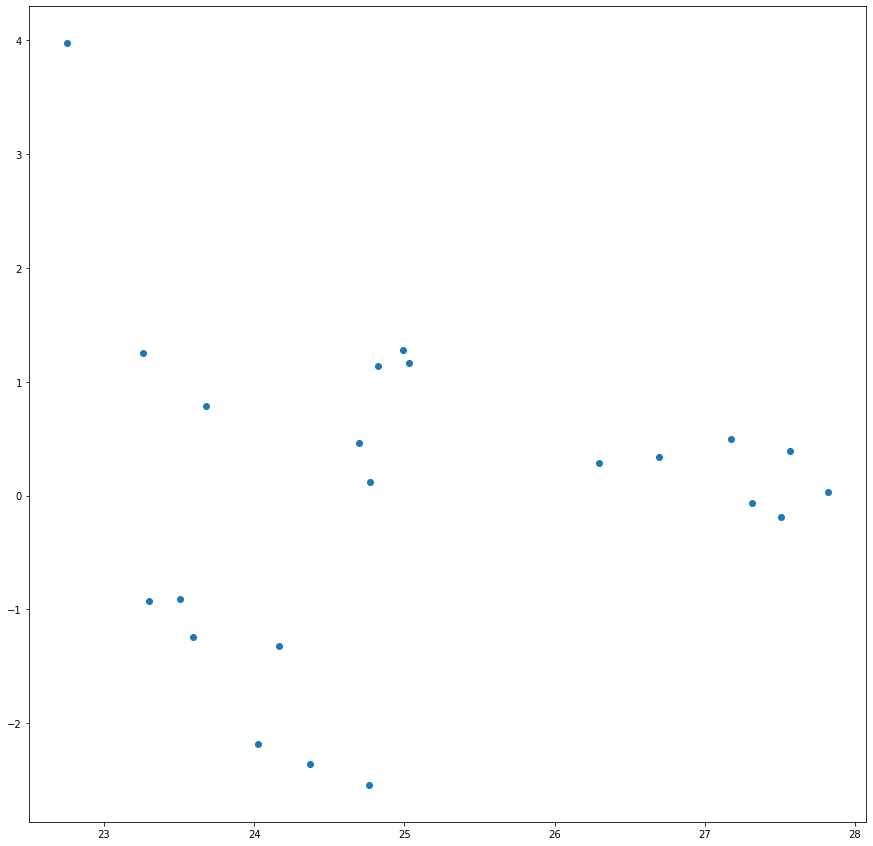

In [25]:
plt.scatter(data["nuclear_share_elec"], model.resid)

In [27]:
np.square(model.resid)

0      0.251926
1      0.035321
2      0.000953
3      0.152157
4      0.004204
5      0.114513
6      0.083925
7      1.630952
8      1.297085
9      1.355059
10     0.217417
11     0.014617
12     1.752184
13     4.769022
14     6.450752
15     5.549563
16     1.545439
17     0.825234
18     0.863814
19     0.626902
20    15.785777
21     1.571915
dtype: float64

In [28]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
resid = model.resid
model_resid_var = np.square(resid)
het_test_bp_nuclear    = het_breuschpagan(resid, add_constant(data["nuclear_share_elec"]))[3]
het_test_bp_renewables = het_breuschpagan(resid, add_constant(data["renewables_share_elec"]))[3]

het_test_white_nuclear    = het_white(resid, add_constant(data["nuclear_share_elec"]))[3]
het_test_white_renewables = het_white(resid, add_constant(data["renewables_share_elec"]))[3]
print("F value for Breusch-Pagan heteroskedasticity test on nuclear_share_elec: ", het_test_bp_nuclear)
print("F value for Breusch-Pagan heteroskedasticity test on renewables_share_elec: ", het_test_bp_renewables)
print("F value for White heteroskedasticity test on nuclear_share_elec: ", het_test_white_nuclear)
print("F value for White heteroskedasticity test on renewables_share_elec: ", het_test_white_renewables)

F value for Breusch-Pagan heteroskedasticity test on nuclear_share_elec:  0.02335106101424373
F value for Breusch-Pagan heteroskedasticity test on renewables_share_elec:  0.004095855602149176
F value for White heteroskedasticity test on nuclear_share_elec:  0.028167458604914274
F value for White heteroskedasticity test on renewables_share_elec:  0.007472994955599069


In [29]:
model_resid_var

0      0.251926
1      0.035321
2      0.000953
3      0.152157
4      0.004204
5      0.114513
6      0.083925
7      1.630952
8      1.297085
9      1.355059
10     0.217417
11     0.014617
12     1.752184
13     4.769022
14     6.450752
15     5.549563
16     1.545439
17     0.825234
18     0.863814
19     0.626902
20    15.785777
21     1.571915
dtype: float64

In [30]:
data["nuclear_share_elec_weighted"] = data["nuclear_share_elec"] / model_resid_var
data["sustainability_weighted"] = data["sustainability"] / model_resid_var
data["renewables_share_elec_weighted"] = data["renewables_share_elec"] / model_resid_var


In [31]:
# Handling heteroskedasticity
model_wls = OLS(data["sustainability_weighted"], add_constant(data[["nuclear_share_elec_weighted", "renewables_share_elec_weighted"]])).fit()
model_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     sustainability_weighted   R-squared:                       1.000
Model:                                 OLS   Adj. R-squared:                  1.000
Method:                      Least Squares   F-statistic:                 5.660e+05
Date:                     Thu, 15 Jun 2023   Prob (F-statistic):           4.33e-46
Time:                             22:26:44   Log-Likelihood:                -96.381
No. Observations:                       22   AIC:                             198.8
Df Residuals:                           19   BIC:                             202.0
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.2103      4.930      0.043      0.966     -10.109      10.529
nuclear_share_elec_weighted        0.5394      0.029     18.704      0.000       0.479       0.600
renewables_share_elec_weighted     0.3700      0.046      7.988      0.000       0.273       0.467
==============================================================================
Omnibus:                       40.637   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.736
Skew:                          -3.062   Prob(JB):                     1.67e-31
Kurtosis:                      13.822   Cond. No.                     8.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
resid = model_wls.resid
het_test_bp    = het_breuschpagan(resid, add_constant(data["nuclear_share_elec_weighted"]))[3]
het_test_white = het_white(resid, add_constant(data["nuclear_share_elec_weighted"]))[3]
print("F value for Breusch-Pagan heteroskedasticity test on nuclear_share_elec: ", het_test_bp_nuclear)
print("F value for Breusch-Pagan heteroskedasticity test on renewables_share_elec: ", het_test_bp_renewables)
print("F value for White heteroskedasticity test on nuclear_share_elec: ", het_test_white_nuclear)
print("F value for White heteroskedasticity test on renewables_share_elec: ", het_test_white_renewables)

F value for Breusch-Pagan heteroskedasticity test on nuclear_share_elec:  0.02335106101424373
F value for Breusch-Pagan heteroskedasticity test on renewables_share_elec:  0.004095855602149176
F value for White heteroskedasticity test on nuclear_share_elec:  0.028167458604914274
F value for White heteroskedasticity test on renewables_share_elec:  0.007472994955599069


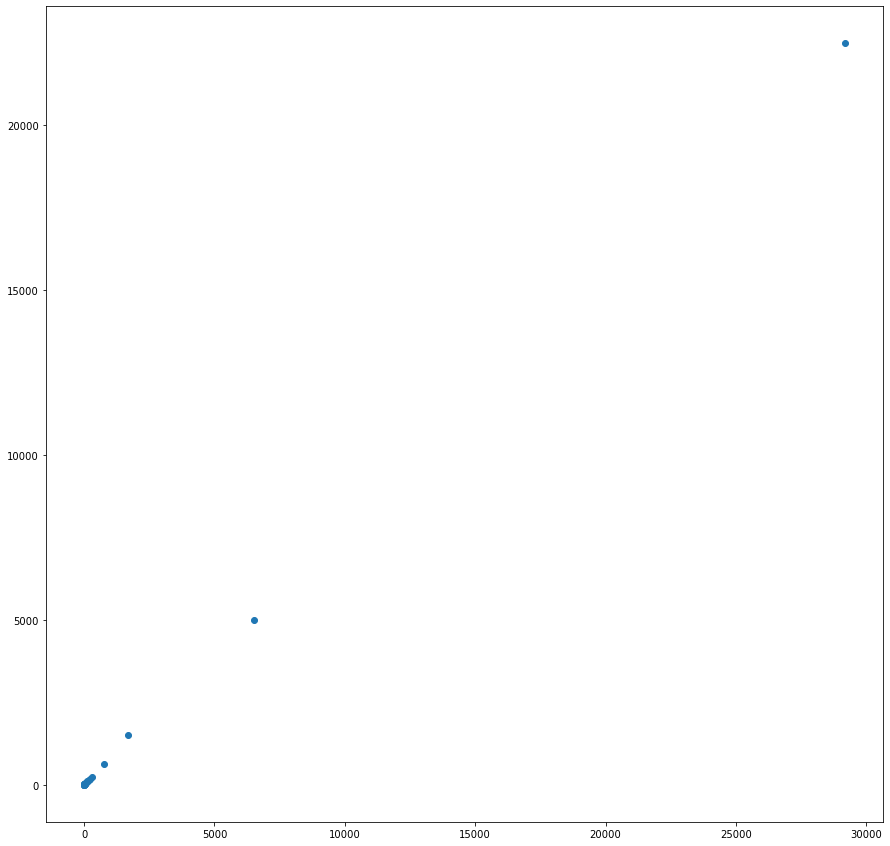

In [34]:
_ = plt.scatter(data["nuclear_share_elec_weighted"], data["sustainability_weighted"])

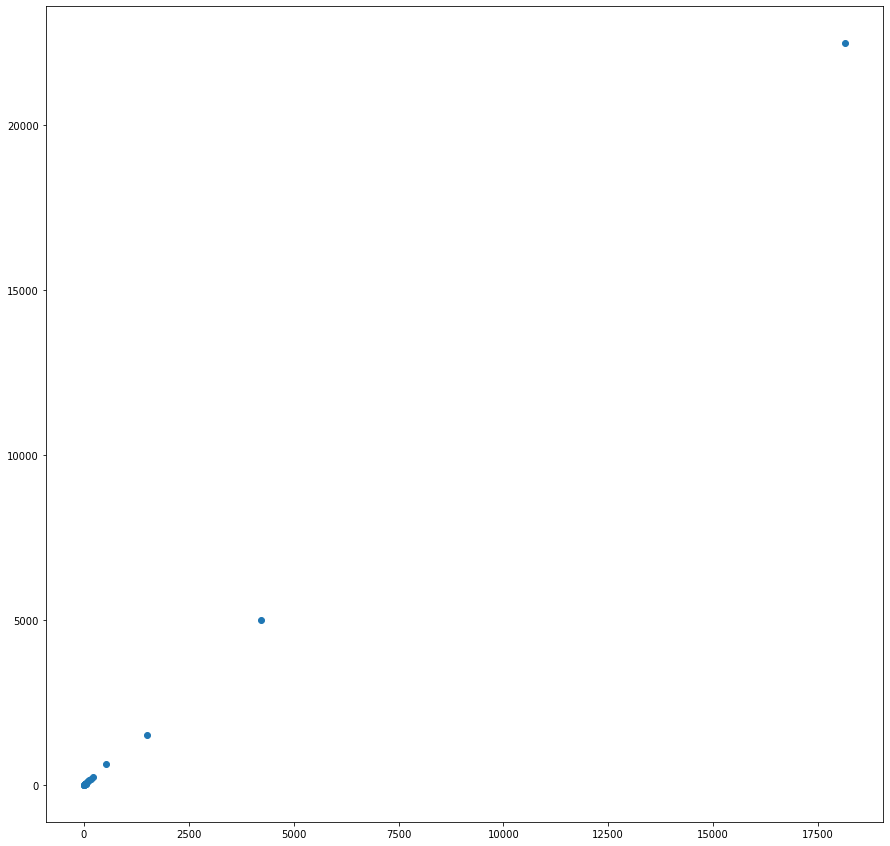

In [35]:
_ = plt.scatter(data["renewables_share_elec_weighted"], data["sustainability_weighted"])

In [39]:
resid = model_wls.resid
het_test_bp_nuclear    = het_breuschpagan(resid, add_constant(data["nuclear_share_elec_weighted"]))[3]
het_test_white_nuclear = het_white(resid, add_constant(data["nuclear_share_elec_weighted"]))[3]
het_test_bp_renewables    = het_breuschpagan(resid, add_constant(data["renewables_share_elec_weighted"]))[3]
het_test_white_renewables = het_white(resid, add_constant(data["renewables_share_elec_weighted"]))[3]
print("F value for Breusch-Pagan heteroskedasticity test on nuclear_share_elec: ", het_test_bp_nuclear)
print("F value for Breusch-Pagan heteroskedasticity test on renewables_share_elec: ", het_test_bp_renewables)
print("F value for White heteroskedasticity test on nuclear_share_elec: ", het_test_white_nuclear)
print("F value for White heteroskedasticity test on renewables_share_elec: ", het_test_white_renewables)

F value for Breusch-Pagan heteroskedasticity test on nuclear_share_elec:  0.3700477099308871
F value for Breusch-Pagan heteroskedasticity test on renewables_share_elec:  0.3458568011694316
F value for White heteroskedasticity test on nuclear_share_elec:  1.7071465202945208e-13
F value for White heteroskedasticity test on renewables_share_elec:  1.0315327439490642e-10


# Autocorrelation tests on model errors

In [40]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print("Ljung-Box test statistics for Model")
print(acorr_ljungbox(model_wls.resid))


Ljung-Box test statistics for Model
    lb_stat  lb_pvalue
1  0.449863   0.502400
2  0.465620   0.792304
3  1.085331   0.780616
4  1.159306   0.884752


In [44]:
model_wls.resid[1:]

1     16.614841
2     15.942789
3     -4.729095
4    -80.363016
5     -2.832831
6    -11.326780
7     -0.735021
8     -0.587020
9      0.724292
10     3.195332
11    28.013816
12    -0.093179
13     0.047327
14     0.223918
15     0.312348
16     2.075209
17     4.563765
18     5.883162
19    13.129355
20     0.665931
21     6.496236
dtype: float64

In [45]:
model_wls.resid.shift()[1:]

1      2.778619
2     16.614841
3     15.942789
4     -4.729095
5    -80.363016
6     -2.832831
7    -11.326780
8     -0.735021
9     -0.587020
10     0.724292
11     3.195332
12    28.013816
13    -0.093179
14     0.047327
15     0.223918
16     0.312348
17     2.075209
18     4.563765
19     5.883162
20    13.129355
21     0.665931
dtype: float64

Text(0, 0.5, 'e_i-1')

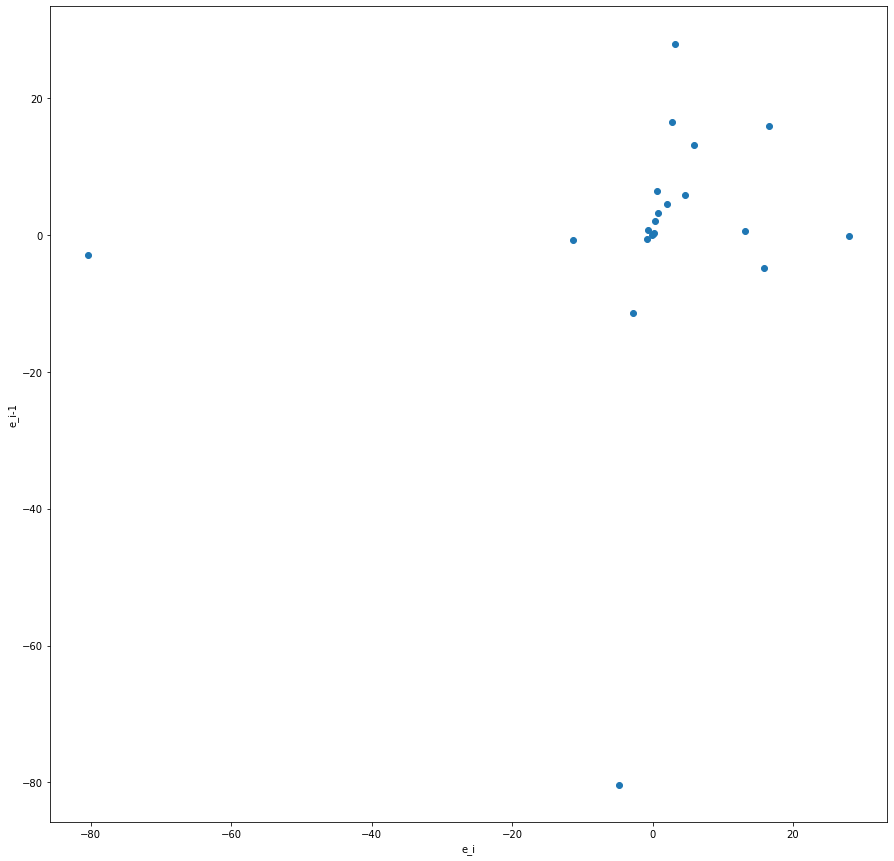

In [47]:
plt.scatter(model_wls.resid.shift()[1:], model_wls.resid[1:])
plt.xlabel("e_i")
plt.ylabel("e_i-1")

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  2., 14.,  4.,  1.]),
 array([-0.21492222, -0.185938  , -0.15695379, -0.12796957, -0.09898536,
        -0.07000114, -0.04101693, -0.01203271,  0.0169515 ,  0.04593571,
         0.07491993]),
 <BarContainer object of 10 artists>)

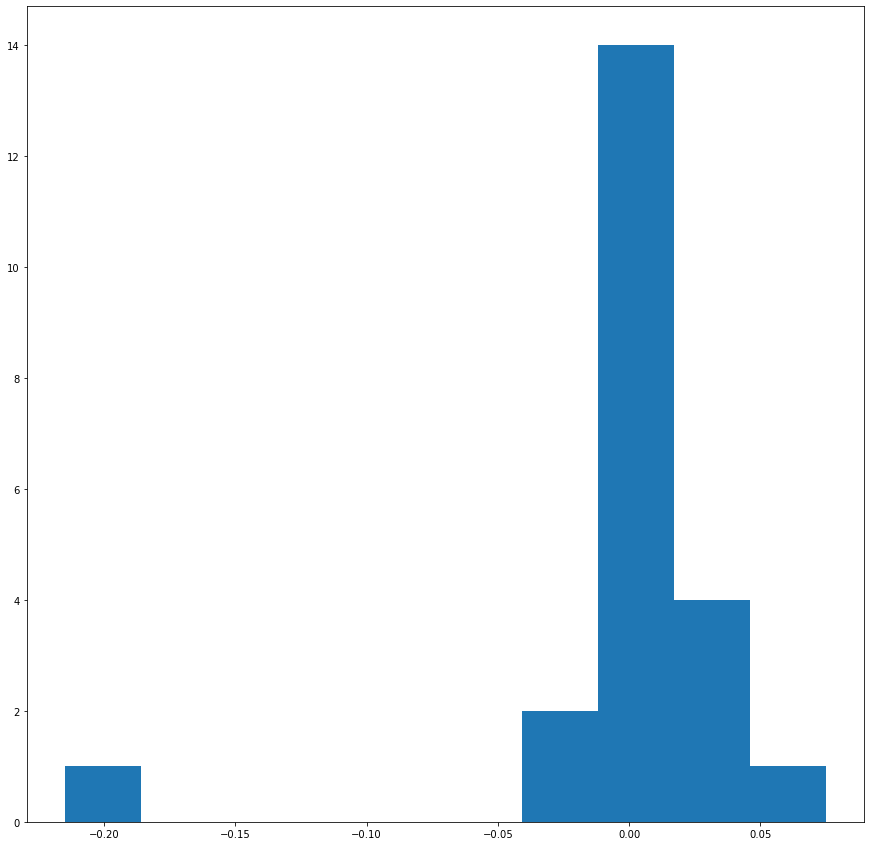

In [50]:
standardized_residuals = (model_wls.resid - np.mean(model_wls.resid))/np.var(model_wls.resid)
plt.hist(standardized_residuals)

In [51]:
shapiro_test_wls = shapiro(standardized_residuals)
print("Shapiro-Wilk test statistic: ", shapiro_test_wls.statistic)
print("Shapiro-Wilk test result: ", shapiro_test_wls.pvalue)
print("Errors are normally distributed" if shapiro_test_wls.pvalue >= 0.05 else "Errors are not normally distributed")

Shapiro-Wilk test statistic:  0.6059134006500244
Shapiro-Wilk test result:  1.5383441223093541e-06
Errors are not normally distributed
